# Исследование отелей в Сочи
Участники и вклад каждого:
- Арзуманян Василий - предварительная обработка данных, разведывательный анализ
- Вежба Анна - визуализация, создание новых признаков, оформление
- Лепехин Алексей - сбор данных, машинное обучение, создание новых признаков

Скоро лето... В связи с непростой геополитической обставкой перед нами встала задача не из легких: как настоящие экономисты мы решили импортозаместить привычные всем путешествия в Турцию и Египет и отправиться в родной СОЧИ!!! С этой целью мы решили проанализировать предложение отелей в этом городе и подобрать наиболее подходящие для нас (бедных студентов) варианты. Так как из-за ряда финансовых ограничений, вызванных санкциями, для нас оказались недоступными часть сайтов по бронированию объектов размещения, мы импортозаместили и сайт - все данные брались с сайта Островок (ссылка представлена в ячейке ниже)

https://ostrovok.ru/hotel/russia/sochi/?q=5580&dates=02.08.2023-03.08.2023&guests=2&price=one&sid=9d434347-dc76-4051-90ca-31aa0c71ae1a

**Примечания к загружаемым файлам**
- hotel_dataset_osnova - датасет после парсинга
- new.csv - датасет после добавления новых признаков
- new_preprocessed.csv - датасет после предобработки (используется в разведывательном анализе данных, визуализации и машинном обучении)

В нашем исследовании мы выдвигаем несколько гипотез:
1. Между звездным рейтингом и ценой существует прямая взаимосвязь
2. Не существует прямой зависимости цены номера от наличия в объекте размещения бара
3. Существует прямая зависимость цены на номер в отеле от предоставления бесплатной парковки
4. Существует обратная зависимость цены на номер в отеле от расстояния до центра города (чем меньше расстояние, тем больше цена)

1. [Сбор данных](#sbor)
2. [Создание новых признаков](#new_pr)
3. [Анализ и обработка данных](#aod)
4. [Разведывательный анализ данных и визуализация](#analysis)
5. [Машинное обучение](#mo)

 <a name="sbor"></a>
## Сбор данных

In [1]:
#импортируем нужные библиотеки
import requests
from bs4 import BeautifulSoup
import time

### Собираем ссылки на сайты

In [2]:
list_with_ref = []
for i in range(1, 55): #54 страниц на сайте со списками отелей, поэтому цикл до 55 невключительно
    begin_of_ref = 'https://ostrovok.ru/hotel/russia/sochi/?q=5580&dates=07.08.2023-08.08.2023&guests=2&'
    fin_of_ref = '&price=one&sid=a350e56e-c1d6-43e1-be0a-0e611823354b'
    url = begin_of_ref + 'page=' + str(i) + fin_of_ref #склеиваем разные куски ссылки
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")
    a_tags = soup.find_all('h2', class_='zen-hotelcard-name')
    linkss = []
    for a_tag in a_tags:
        link = a_tag.find('a')['href'] #ищем ссылку на отель 
        linkss.append(link)
    beg = '?q=5580&dates=07.08.2023-08.08.2023&guests=2&price=one&room=s-e010a429-f378-510f-9c86-d40f1eafaeb5&serp_price='
    fin = '.5627.RUB.h-3de03a5a-5862-5319-b7a6-3c0e7867aefe&sid=a350e56e-c1d6-43e1-be0a-0e611823354b'
    for i in range (len(linkss)):
        linkss[i] = 'https://ostrovok.ru/' + linkss[i].split('/')[1] + '/' \
        + linkss[i].split('/')[2] + '/' + linkss[i].split('/')[3] + '/' + str('mid10370458') + '/' \
        + linkss[i].split('/')[-2] + '/' + beg + linkss[i].split('/')[-2] + fin 
        #склеиваем ссылку (были небольшие сложности с их открытием, которые пришлось обходить, склеивая их такими кусками)
    list_with_ref.extend(linkss)
    time.sleep(2) #ждем 2 секунды, чтобы не получить бан

In [3]:
#записываем полученные ссылки в файл, чтобы не потерялись и каждый раз не пришлось парсить по новой
with open("file.txt", 'w') as f: 
    for s in list_with_ref:
        f.write(str(s) + '\n')

### Работаем с ссылками уже на конкретные отели и парсим информацию об объектах

In [4]:
with open("file.txt", 'r') as f:
    refs = [line.rstrip('\n') for line in f]

In [5]:
len(set(refs))

1350

Как можно заметить, получилось 1350 уникальных ссылок на объекты проживания, что очень хорошо, так как выборка получится большой. 

Главное, чтобы дальше не получилось много пропусков

In [6]:
#теперь в списке хранятся ссылки на отели
refs[:3]

['https://ostrovok.ru/hotel/russia/esto-sadok/mid10370458/alcont/?q=5580&dates=07.08.2023-08.08.2023&guests=2&price=one&room=s-e010a429-f378-510f-9c86-d40f1eafaeb5&serp_price=alcont.5627.RUB.h-3de03a5a-5862-5319-b7a6-3c0e7867aefe&sid=a350e56e-c1d6-43e1-be0a-0e611823354b',
 'https://ostrovok.ru/hotel/russia/sochi/mid10370458/antika/?q=5580&dates=07.08.2023-08.08.2023&guests=2&price=one&room=s-e010a429-f378-510f-9c86-d40f1eafaeb5&serp_price=antika.5627.RUB.h-3de03a5a-5862-5319-b7a6-3c0e7867aefe&sid=a350e56e-c1d6-43e1-be0a-0e611823354b',
 'https://ostrovok.ru/hotel/russia/esto-sadok/mid10370458/apartamentyi_goryi/?q=5580&dates=07.08.2023-08.08.2023&guests=2&price=one&room=s-e010a429-f378-510f-9c86-d40f1eafaeb5&serp_price=apartamentyi_goryi.5627.RUB.h-3de03a5a-5862-5319-b7a6-3c0e7867aefe&sid=a350e56e-c1d6-43e1-be0a-0e611823354b']

In [7]:
#создаем датасет, куда будем записывать собранные данные об отелях
import pandas as pd
df = pd.DataFrame()
col_names = ['Name', 'User_rating', 'Reviews_count', 'Star_rating', 'Distance_from_center', 'Amenities', 'Price']
df = pd.DataFrame(columns= col_names)
df

,Name,User_rating,Reviews_count,Star_rating,Distance_from_center,Amenities,Price


In [8]:
for i in range (len(refs)):
    response = requests.get(refs[i])
    soup = BeautifulSoup(response.text, 'html.parser') #получаем html-код страницы
    hotel_name_tag = soup.find('script', type='application/ld+json') #ищем нужную информацию со страницы
    if str(hotel_name_tag) == 'None': #если None, то информация об отеле скрыта, не учитываем ее в датасете
        pass
    else:
        name = str(hotel_name_tag).split('\n')[4].strip().split(':')[1].split('"')[1]
        b = str(hotel_name_tag).split('\n')
        if 'starRating' not in str(hotel_name_tag):
            if 'aggregateRating' in str(hotel_name_tag):
                num_rate = b.index('        "aggregateRating": {') #отвечает за пользовательский рейтинг
                user_rating = float(b[num_rate + 3].split(':')[1].strip().strip(','))
                user_reviews = int(b[num_rate + 4].split(':')[1].strip().strip(','))
                star_rating = 'No stars'
                if 'price' in str(hotel_name_tag):
                    price = float(b[num_rate + 12].split(':')[1].strip().strip('",'))
        else:
            num_star = b.index('        "starRating": {') #отвечает за звездный рейтинг
            star_rating = float(b[num_star + 2].split(':')[1].strip().strip(',"'))
            user_rating = float(b[num_star + 9].split(':')[1].strip().strip(',"'))
            user_reviews = int(b[num_star + 10].split(':')[1].strip().strip(',"'))
            price = float(b[num_star + 18].split(':')[1].strip().strip(',"'))
        distance_value = soup.find('span', class_='zen-roomspage-title-distance-value').text #отвечает за расстояние до центра города
        distance_from_center = int(distance_value.split()[0])
        amenities = []
        for p in soup.find_all('p', class_='zen-roomspage-amenities-amenity'):#отвечает за дополнительные удобства
            amenity = p.text
            amenities.append(amenity)
        #записываем получившиеся значения в таблицу
        df.loc[i] = [name, user_rating, user_reviews, star_rating, distance_from_center, amenities, price]
    time.sleep(3.5) #после каждой итерации программа отдыхает 3,5 секунды, чтобы не нарваться на бан

In [9]:
df.head(5)

,Name,User_rating,Reviews_count,Star_rating,Distance_from_center,Amenities,Price
0,Отель Alcont,8.2,107.0,4.0,317,"['Сауна', 'Конференц-зал', 'Магазины', 'Лифт',...",2992.0
1,Отель Антика,8.8,99.0,3.0,3338,"['Факс и ксерокс', 'Кондиционер', 'Удобства дл...",4213.0
2,Апартаменты Горы,9.0,96.0,No stars,1145,[],3214.0
3,Апарт-отель &quot;Метрополь&quot;,9.0,116.0,4.0,1875,[],10299.0
4,Гостевой дом Black sea guest house,9.0,103.0,No stars,24457,"['Сауна', 'Факс и ксерокс', 'Кондиционер', 'Те...",6950.0


*Получился датасет с 7 признаками:*
- Название объекта проживания


- Пользовательский рейтинг


- Число отзывов


- Звездный рейтинг


- Удаленность от центра города


- Список с дополнительными удобстваии


- Цена за один день проживания


In [39]:
df.shape

(1337, 7)

Как мы видим, получилось из 1350 объектов 1337 добавились в датасет, что достаточно неплохо - лишь о 13 отелях не получилось спарсить никакой информации (теги с информацией были скрыты)

In [11]:
#сохраняем датасет в файл, чтобы было удобно работать в дальнейшем, и не потерять и заново парсить
df.to_csv('hotel_dataset_osnova')

 <a name="new_pr"></a>
## Создание новых признаков

In [12]:
#выгружаем датасет без колонки Unnamed, дублирующий индекс (можно было удалить сразу, но уже поздно)
data = pd.read_csv('hotel_dataset_osnova')
data.drop(columns = 'Unnamed: 0', inplace = True)

In [13]:
data.head()

,Name,User_rating,Reviews_count,Star_rating,Distance_from_center,Amenities,Price
0,Отель Alcont,8.2,107.0,4.0,317,"['Сауна', 'Конференц-зал', 'Магазины', 'Лифт',...",2992.0
1,Отель Антика,8.8,99.0,3.0,3338,"['Факс и ксерокс', 'Кондиционер', 'Удобства дл...",4213.0
2,Апартаменты Горы,9.0,96.0,No stars,1145,[],3214.0
3,Апарт-отель &quot;Метрополь&quot;,9.0,116.0,4.0,1875,[],10299.0
4,Гостевой дом Black sea guest house,9.0,103.0,No stars,24457,"['Сауна', 'Факс и ксерокс', 'Кондиционер', 'Те...",6950.0


### Преобразуем колонку Amenities
В ней лежат списки с дополнительными удобствами, нас это не устраивает, так как с ними мы не можем работать


Для начала посмотрим на все встречающиеся дополнительные удобства:

In [14]:
amenities = []
for i in range(len(data)):
    for elem in range(len(data['Amenities'][i])):
        lst = data['Amenities'][i].split(',')
        for f in range(len(lst)):
            amenities.append(lst[f].strip("''[] "))
set(amenities)

{'',
 'Wi-Fi',
 'Wi-fi в отеле',
 'Аквапарк',
 'Аптека',
 'Аптечка первой помощи',
 'Бадминтон',
 'Банкомат',
 'Баня',
 'Бар',
 'Бассейн',
 'Бесплатная общественная парковка поблизости',
 'Бесплатная парковка',
 'Бесплатная парковка рядом с отелем',
 'Бесплатное размещение с домашними животными',
 'Бесплатный Wi-Fi',
 'Бесплатный прокат велосипедов',
 'Бесплатный трансфер',
 'Бесплатный трансфер до горнолыжного склона',
 'Бесплатный трансфер до пляжа',
 'Бесплатный трансфер от/до аэропорта',
 'Бесплатный трансфер от/до жд вокзала',
 'Бесплатный чай/кофе',
 'Библиотека',
 'Бизнес-центр',
 'Бильярд',
 'Боулинг',
 'Верховая езда',
 'Виндсерфинг',
 'Винодельческое хозяйство',
 'Возможен полный пансион',
 'Врач',
 'Гладильные принадлежности',
 'Гладильные услуги',
 'Дайвинг',
 'Дартс',
 'Детская игровая площадка',
 'Детские телеканалы',
 'Детский бассейн',
 'Детский клуб',
 'Джакузи',
 'Диетическое меню (по запросу)',
 'Доступ в интернет',
 'Доступ на лыжах к отелю',
 'Завтрак',
 'Завтрак в

Отберем удобства, которые мы считаем наиболее важными при выборе отеля, а именно:
- наличие доступа к интернету

- бесплатный трансфер от/до аэропорта

- наличие развлечений для детей

- наличие бара

- наличие бесплатной парковки

In [15]:
import warnings
warnings.filterwarnings('ignore')

Создаем новые колонки: Wi-Fi (бесплатный Wi-Fi), free_transfer (Бесплатный трансфер от/до аэропорта), child_service (развлечения для детей), bar (наличие бара), parking (наличие парковки)
Так как есть пустые колонки, то заполним их NaN'ами, чтобы впоследствии при обработке данных они высвечивались как пропуски 
Принцип для создания новых 5 признаков простой: 
- создаем пустую колонку, заполненную нулями;
- проходим по датасету по колонке Amenities;
- если в списке Amenities i-го объекта есть ключевое слово, то меняем значение новой колонки на 1;
- если список Amenities i-го объекта пустой, меняем значение на NaN;
- если список Amenities i-го объекта непустой и не содержит ключевого слова, меняем значение на 0 (фактически оставляем изначальным).

In [16]:
data['Wi-Fi'] = 0
for i in range (len(data)):
    if 'Wi-Fi' in data['Amenities'][i]:
        data['Wi-Fi'][i] = 1
    elif data['Amenities'][i] == '[]':
        data['Wi-Fi'][i] = 'NaN'
    else:
        data['Wi-Fi'][i] = 0

In [17]:
data['free_transfer'] = 0
for i in range (len(data)):
    if 'Бесплатный трансфер от/до аэропорта' in data['Amenities'][i]:
        data['free_transfer'][i] = 1
    elif data['Amenities'][i] == '[]':
        data['free_transfer'][i] = 'NaN'
    else:
        data['free_transfer'][i] = 0

In [18]:
data['child_service'] = 0
for i in range (len(data)):
    if 'Детск' in data['Amenities'][i]:
        data['child_service'][i] = 1
    elif data['Amenities'][i] == '[]':
        data['child_service'][i] = 'NaN'
    else:
        data['child_service'][i] = 0

In [19]:
data['bar'] = 0
for i in range (len(data)):
    if 'Бар' in data['Amenities'][i]:
        data['bar'][i] = 1
    elif data['Amenities'][i] == '[]':
        data['bar'][i] = 'NaN'
    else:
        data['bar'][i] = 0

In [20]:
data['parking'] = 0
for i in range (len(data)):
    if 'Парковка отсутствует' in data['Amenities'][i]:
        data['parking'][i] = 0
    elif data['Amenities'][i] == '[]':
        data['parking'][i] = 'NaN'
    elif 'Парковка' in data['Amenities'][i]:
        data['parking'][i] = 1
    else:
        data['parking'][i] = 0

### Преобразуем колонку Name
Из названия объекта размещения можно узнать его тип - отель, хостел, гостевой дом, апартаменты. Данный признак, как нам кажется, является важным и может повлиять на выбор места проживания, поэтому создадим новый признак type_hotel 

После пристального взора на наш датасет, мы обнаружили, что в основном типы объектов проживания содержат следующие ключевые слова:

In [21]:
types = ["Krasnaya Polyana", "Гостевой дом","Hotel", "Resort", "Отель", "Хостел", "Апарт-отель", "Apart-hotel", "Апартамент", "Apartments", "Пансион", "Санаторий", \
         "ЖК", "Гостиница", "Radisson", "Рэдиссон", \
        "Hostel", "Комплекс", "База отдыха"] 

Сначала достанем их из колонки Name и запишем в новую колонку type_hotel:

In [22]:
data['type_hotel'] = 0
for i in range(len(data)):
    type_hot = 'NaN'
    for elem in range(len(types)):
        if types[elem].lower() in data['Name'][i].lower():
            type_hot = types[elem]
    if type_hot == 'NaN':
        if 'Apart'.lower() in data['Name'][i].lower() or 'Апарт'.lower() in data['Name'][i].lower():
            type_hot = types[elem]
    data['type_hotel'][i] = type_hot

In [23]:
data.head(5)

,Name,User_rating,Reviews_count,Star_rating,Distance_from_center,Amenities,Price,Wi-Fi,free_transfer,child_service,bar,parking,type_hotel
0,Отель Alcont,8.2,107.0,4.0,317,"['Сауна', 'Конференц-зал', 'Магазины', 'Лифт',...",2992.0,1,0,0,1,1,Отель
1,Отель Антика,8.8,99.0,3.0,3338,"['Факс и ксерокс', 'Кондиционер', 'Удобства дл...",4213.0,1,0,0,0,1,Отель
2,Апартаменты Горы,9.0,96.0,No stars,1145,[],3214.0,NaN,NaN,NaN,NaN,NaN,Апартамент
3,Апарт-отель &quot;Метрополь&quot;,9.0,116.0,4.0,1875,[],10299.0,NaN,NaN,NaN,NaN,NaN,Апарт-отель
4,Гостевой дом Black sea guest house,9.0,103.0,No stars,24457,"['Сауна', 'Факс и ксерокс', 'Кондиционер', 'Те...",6950.0,1,0,0,1,1,Гостевой дом


Теперь приведем получившиеся значения к более узкой классификации, для этого разобьем все места проживания на 5 типов:

In [24]:
hotels = ['Отель', 'Hotel', 'Гостиница', 'Комплекс', 'Radisson', 'Рэдиссон'] #отели
hostels = ['Хостел', 'Hostel'] #хостелы
apartments = ['Апартамент', 'Апарт-отель', 'ЖК', 'Apartments',  'Apart-hotel'] #апартаменты
guest_house = ['Гостевой дом'] # гостевые дома
resort = ['Resort', 'Krasnaya Polyana', 'Санаторий', "База отдыха", "Пансион"] #курорты, базы отдыха

In [25]:
for i in range (len(data)):
    if data['type_hotel'][i] in hotels:
        data['type_hotel'][i] = "Отель"
    elif data['type_hotel'][i] in hostels:
        data['type_hotel'][i] = "Хостел"
    elif data['type_hotel'][i] in apartments:
        data['type_hotel'][i] = "Апартаменты"
    elif data['type_hotel'][i] in guest_house:
        data['type_hotel'][i] = 'Гостевой дом'
    elif data['type_hotel'][i] in resort:
        data['type_hotel'][i] = 'Курорт'

После того как мы сделали все, что хотели с колонкой имени (Name) и удобств (Amenities), а именно создали по ним новые признаки, можем со спокойной душой удалить Name и Amenities

In [26]:
data.drop(columns = ['Amenities', 'Name'], inplace = True)

In [27]:
data.head()

,User_rating,Reviews_count,Star_rating,Distance_from_center,Price,Wi-Fi,free_transfer,child_service,bar,parking,type_hotel
0,8.2,107.0,4.0,317,2992.0,1,0,0,1,1,Отель
1,8.8,99.0,3.0,3338,4213.0,1,0,0,0,1,Отель
2,9.0,96.0,No stars,1145,3214.0,NaN,NaN,NaN,NaN,NaN,Апартаменты
3,9.0,116.0,4.0,1875,10299.0,NaN,NaN,NaN,NaN,NaN,Апартаменты
4,9.0,103.0,No stars,24457,6950.0,1,0,0,1,1,Гостевой дом


### Преобразуем колонку Star_rating

In [28]:
data.Star_rating.value_counts()

No stars    991
3.0         153
4.0          83
2.0          52
5.0          16
1.0          11
Name: Star_rating, dtype: int64

Как мы видим, большинство объектов проживания не имеют звезд (возможно, потому что они относятся к апартаментам, гостевым домам, у которых нет звездного рейтинга), заменим значение No stars на 0

In [29]:
data.Star_rating.replace('No stars', 0, inplace = True)

После добавления новых признаков, снова сохраним наш датасет, на очереди обработка и заполнение пропусков
Сохраним датасет снова, чтобы не потерять уже сделанное

In [43]:
data.to_csv('New.csv', index = False)

 <a name="aod"></a>
## Анализ и обработка данных

In [30]:
dt = pd.read_csv('New.csv')
dt.head()

,User_rating,Reviews_count,Star_rating,Distance_from_center,Price,Wi-Fi,free_transfer,child_service,bar,parking,type_hotel
0,8.2,107.0,4.0,317,2992.0,1.0,0.0,0.0,1.0,1.0,Отель
1,8.8,99.0,3.0,3338,4213.0,1.0,0.0,0.0,0.0,1.0,Отель
2,9.0,96.0,0.0,1145,3214.0,NaN,NaN,NaN,NaN,NaN,Апартаменты
3,9.0,116.0,4.0,1875,10299.0,NaN,NaN,NaN,NaN,NaN,Апартаменты
4,9.0,103.0,0.0,24457,6950.0,1.0,0.0,0.0,1.0,1.0,Гостевой дом


In [31]:
dt.shape

(1337, 11)

Посмотрим на пропуски:

In [32]:
dt.isna().sum()

User_rating              31
Reviews_count            31
Star_rating              31
Distance_from_center      0
Price                    31
Wi-Fi                   862
free_transfer           862
child_service           862
bar                     862
parking                 862
type_hotel               31
dtype: int64

Так как пропусков получилось много (особенно в колонках с дополнительными услугами, но важные, то попытаемся как-то предобработать их)

Для начала отберем только те строки, где количество отзывов больше 10

In [33]:
dt = dt[dt.Reviews_count > 10]
dt.shape

(610, 11)

In [34]:
dt.isna().sum()

User_rating               0
Reviews_count             0
Star_rating               0
Distance_from_center      0
Price                     0
Wi-Fi                   300
free_transfer           300
child_service           300
bar                     300
parking                 300
type_hotel               17
dtype: int64

Как мы видим, новый датасет содержит 610 строк (убавилось, к сожалению, целых 727 строк), но при этом наша выборка все еще больше 500 объектов и к тому же количество пропусков в колонках с удобствами (Wi-Fi, free_transfer, child_service, bar, parking, type_hotel) сократилось на 562, то есть 77% удаленных строчек было с пропусками

Пропусков все еще много, но будем работать с ними

Посмотрим на распределение признаков с 300 пропусками:

In [35]:
columns = ['Wi-Fi', 'free_transfer', 'child_service', 'bar', 'parking']
for i in range (5):
    print(dt[columns[i]].value_counts())

1.0    294
0.0     16
Name: Wi-Fi, dtype: int64
0.0    305
1.0      5
Name: free_transfer, dtype: int64
0.0    261
1.0     49
Name: child_service, dtype: int64
0.0    166
1.0    144
Name: bar, dtype: int64
1.0    219
0.0     91
Name: parking, dtype: int64


Заполним пропущенные значения модами, так как данная переменная - индикатор, где 1 - наличие услуги, 0 - ее отсутствие, поэтому заменять пропуски медианой или средним значением нам показалось нецелесообразно:

In [36]:
def fillna_mode(data, column):
    mode = data[column].mode()[0]
    data[column].fillna(mode, inplace = True)
    return data[column]

In [37]:
columns = ['Wi-Fi', 'free_transfer', 'child_service', 'bar', 'parking']
for i in range (5):
    fillna_mode(data = dt, column = columns[i])

In [38]:
dt.isna().sum()

User_rating              0
Reviews_count            0
Star_rating              0
Distance_from_center     0
Price                    0
Wi-Fi                    0
free_transfer            0
child_service            0
bar                      0
parking                  0
type_hotel              17
dtype: int64

In [39]:
dt[dt.User_rating > 10]

,User_rating,Reviews_count,Star_rating,Distance_from_center,Price,Wi-Fi,free_transfer,child_service,bar,parking,type_hotel
852,9712.0,29.0,3.0,1807,9712.0,1.0,0.0,0.0,0.0,1.0,Отель


Осталось 17 пропусков в колонках с типами отелей, удалим такие строчки, также удалим строчки, в которых пользовательский рейтинг превышает 10 (в датасете обнаружилось одно аномальное значение)

In [40]:
dt.dropna(inplace = True)
dt = dt[dt.User_rating <= 10]
dt.head()

,User_rating,Reviews_count,Star_rating,Distance_from_center,Price,Wi-Fi,free_transfer,child_service,bar,parking,type_hotel
0,8.2,107.0,4.0,317,2992.0,1.0,0.0,0.0,1.0,1.0,Отель
1,8.8,99.0,3.0,3338,4213.0,1.0,0.0,0.0,0.0,1.0,Отель
2,9.0,96.0,0.0,1145,3214.0,1.0,0.0,0.0,0.0,1.0,Апартаменты
3,9.0,116.0,4.0,1875,10299.0,1.0,0.0,0.0,0.0,1.0,Апартаменты
4,9.0,103.0,0.0,24457,6950.0,1.0,0.0,0.0,1.0,1.0,Гостевой дом


In [41]:
dt.describe()

,User_rating,Reviews_count,Star_rating,Distance_from_center,Price,Wi-Fi,free_transfer,child_service,bar,parking
count,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000
mean,8.526351,39.523649,1.304054,8786.604730,6271.369932,0.976351,0.006757,0.079392,0.234797,0.851351
std,0.848577,39.398602,1.658323,11014.400971,4638.545362,0.152080,0.081991,0.270578,0.424231,0.356043
min,5.300000,11.000000,0.000000,42.000000,500.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.000000,16.000000,0.000000,1004.750000,3699.500000,1.000000,0.000000,0.000000,0.000000,1.000000
50%,8.700000,26.000000,0.000000,2577.500000,5000.000000,1.000000,0.000000,0.000000,0.000000,1.000000
75%,9.100000,44.000000,3.000000,18536.000000,7506.250000,1.000000,0.000000,0.000000,0.000000,1.000000
max,10.000000,388.000000,5.000000,49879.000000,44737.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [42]:
dt.shape

(592, 11)

Получившийся датасет содержит 592 строчки, сохраним его в новый файл и будем работать уже с ним

In [43]:
dt.to_csv('New_preprocessed.csv', index = False)

 <a name="analysis"></a>
## Разведывательный анализ данных и визуализация

In [44]:
data = pd.read_csv('New_preprocessed.csv')

In [45]:
data.corr()

,User_rating,Reviews_count,Star_rating,Distance_from_center,Price,Wi-Fi,free_transfer,child_service,bar,parking
User_rating,1.000000,0.081525,0.034337,-0.122050,0.164089,0.066460,-0.026883,-0.030498,-0.012046,0.137876
Reviews_count,0.081525,1.000000,0.351193,-0.090754,0.197620,0.000941,-0.037763,-0.012160,0.260802,-0.037504
Star_rating,0.034337,0.351193,1.000000,0.011677,0.446368,0.062105,-0.015135,0.044156,0.405836,-0.017892
Distance_from_center,-0.122050,-0.090754,0.011677,1.000000,-0.041921,-0.010923,0.050442,0.077191,0.085516,-0.078714
Price,0.164089,0.197620,0.446368,-0.041921,1.000000,0.003229,-0.032405,0.047441,0.329151,0.002387
Wi-Fi,0.066460,0.000941,0.062105,-0.010923,0.003229,1.000000,0.012836,0.004584,0.007531,0.184961
free_transfer,-0.026883,-0.037763,-0.015135,0.050442,-0.032405,0.012836,1.000000,0.052049,0.002958,-0.081461
child_service,-0.030498,-0.012160,0.044156,0.077191,0.047441,0.004584,0.052049,1.000000,0.146884,-0.088056
bar,-0.012046,0.260802,0.405836,0.085516,0.329151,0.007531,0.002958,0.146884,1.000000,-0.082201
parking,0.137876,-0.037504,-0.017892,-0.078714,0.002387,0.184961,-0.081461,-0.088056,-0.082201,1.000000


In [46]:
data.describe()

,User_rating,Reviews_count,Star_rating,Distance_from_center,Price,Wi-Fi,free_transfer,child_service,bar,parking
count,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000
mean,8.526351,39.523649,1.304054,8786.604730,6271.369932,0.976351,0.006757,0.079392,0.234797,0.851351
std,0.848577,39.398602,1.658323,11014.400971,4638.545362,0.152080,0.081991,0.270578,0.424231,0.356043
min,5.300000,11.000000,0.000000,42.000000,500.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.000000,16.000000,0.000000,1004.750000,3699.500000,1.000000,0.000000,0.000000,0.000000,1.000000
50%,8.700000,26.000000,0.000000,2577.500000,5000.000000,1.000000,0.000000,0.000000,0.000000,1.000000
75%,9.100000,44.000000,3.000000,18536.000000,7506.250000,1.000000,0.000000,0.000000,0.000000,1.000000
max,10.000000,388.000000,5.000000,49879.000000,44737.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [47]:
data['type_hotel'].value_counts().sort_values(ascending = False)

Отель           317
Гостевой дом    133
Апартаменты     117
Хостел           17
Курорт            8
Name: type_hotel, dtype: int64

Более половины выборки составляют отели, гостевых домов и апартаментов меньше, их примерно поровну; хостелов и курортов гораздо меньше

In [48]:
data.groupby('type_hotel').Price.mean().sort_values(ascending = False)

type_hotel
Курорт          8976.250000
Отель           7279.794953
Апартаменты     6473.965812
Гостевой дом    3942.796992
Хостел          3017.647059
Name: Price, dtype: float64

In [154]:
data.groupby('type_hotel').Price.median().sort_values(ascending = False)

type_hotel
Курорт          8057.0
Апартаменты     5842.0
Отель           5697.0
Гостевой дом    3799.0
Хостел          3326.0
Name: Price, dtype: float64

- Цена за номер в курортах (базах отдыха) в среднем самые дорогие
- Номер в отеле, в среднем, стоит дешевле номера на базах отдыха; плата за апартаменты, в среднем, ниже платы за отели, при этом медиана цены за апартаменты выше, чем у отелей, поэтому можно выдвинуть гипотезу о том, что среди отелей содержатся выбросы по цене (может быть это отели премиум-класса)
- Гостевые дома и хостелы самые дешевые.  В среднем, хостел почти в 2,5 раза дешевле номера в отеле и почти в 3 раза дешевле номера на базе отдыха. 


In [49]:
data.groupby('type_hotel').User_rating.mean().sort_values(ascending = False)

type_hotel
Апартаменты     8.829060
Курорт          8.537500
Гостевой дом    8.483459
Отель           8.463091
Хостел          7.952941
Name: User_rating, dtype: float64

In [155]:
data.groupby('type_hotel').User_rating.median().sort_values(ascending = False)

type_hotel
Апартаменты     8.90
Гостевой дом    8.70
Курорт          8.65
Отель           8.60
Хостел          8.00
Name: User_rating, dtype: float64

Средний рейтинг пользователей по типам объекта проживания:
- Самый высокий рейтинг у апартаментов, причем как средний, так и медианный
- Ненамного ниже рейтинг курортов, гостевых домов и отелей. Средний рейтинг данных типов мест проживания отличается незначительно - от 8,46 у отелей до 8,54 у курортов. Медианный рейтинг данных типов также варьируется незначительно
- Самый низкий рейтинг - у хостелов: 7,9. 

In [50]:
data.groupby('type_hotel').Reviews_count.mean().sort_values(ascending = False)

type_hotel
Курорт          80.875000
Отель           48.583596
Хостел          34.058824
Апартаменты     28.888889
Гостевой дом    25.496241
Name: Reviews_count, dtype: float64

In [156]:
data.groupby('type_hotel').Reviews_count.median().sort_values(ascending = False)

type_hotel
Курорт          67.5
Отель           34.0
Хостел          25.0
Апартаменты     21.0
Гостевой дом    21.0
Name: Reviews_count, dtype: float64

- В нашей выборке мало курортов - они составляют лишь 1.3% от выборки, возможно за счет этого их показатель числа отзывов выше отелей
- Хотя хостелы также составляют маленький процент выборки - 2,8%, среднее число отзывов более, чем в два раза меньше, чем у баз отдыха. Можно предположить, что курорты, в среднем, популярнее
- Среднее число отзывов на отели почти в два раза выше числа отзывов на апартаменты и гостевые дома


In [51]:
data.groupby('type_hotel').Distance_from_center.mean().sort_values(ascending = False)

type_hotel
Курорт          12475.750000
Гостевой дом    10951.330827
Отель            9349.526814
Хостел           5165.705882
Апартаменты      5074.529915
Name: Distance_from_center, dtype: float64

In [157]:
data.groupby('type_hotel').Distance_from_center.median().sort_values(ascending = False)

type_hotel
Курорт          3971.0
Отель           3028.0
Гостевой дом    2905.0
Апартаменты     1610.0
Хостел          1033.0
Name: Distance_from_center, dtype: float64

- Курорты, гостевые дома, отели расположены дальше от центра города, чем хостелы и апартаменты. Возможно, значительная доля отелей, гостевых домов и курортов расположена за чертой города, вблизи пляжей
- Хостелы и апартаменты, в среднем, расположены ближе к центру города
- То, что медианное расстояние от центра города у курортов, отелей и гостевых домов значительно ниже среднего расстояния от центра города, наводит на мысли о выбросах, которые существенно завышают средний показатель

In [52]:
data[data.Star_rating > 0].groupby('type_hotel')['Star_rating'].value_counts()

type_hotel    Star_rating
Апартаменты   3.0             12
              4.0             10
Гостевой дом  3.0              4
              2.0              3
              4.0              1
Курорт        4.0              3
              3.0              2
              5.0              2
              2.0              1
Отель         3.0            108
              4.0             53
              2.0             26
              5.0             10
              1.0              6
Name: Star_rating, dtype: int64

- У 66% отелей есть звездный рейтинг. Почти 55% из них имеют трехзвездночный рейтинг, 26% - четырехзвездочный. Около 5% - пятизвездочные, при этом на одно- и двухзвездочные отели приходится около 14%
- Хотя курортов в нашей выборке и мало, все они имеют звездный рейтинг, 37.5% - четырехзвездочные, по 25% приходится на пятизвездочные и трехзвездочные
- В данных о звездном рейтинге апартаментов и гостевых домов много нулевых значений - следствие большого количества пропусков в данных (многие места размещения такого типа попросту не имеют звездного рейтинга). Лишь 10% апартаментов и гостевых домов, в среднем, имеют звездный рейтинг

In [53]:
for i in range(len(columns)):
    print(data.groupby(columns[i])['type_hotel'].value_counts())
    print('-' * 100)

Wi-Fi  type_hotel  
0.0    Отель             8
       Гостевой дом      5
       Апартаменты       1
1.0    Отель           309
       Гостевой дом    128
       Апартаменты     116
       Хостел           17
       Курорт            8
Name: type_hotel, dtype: int64
----------------------------------------------------------------------------------------------------
free_transfer  type_hotel  
0.0            Отель           313
               Гостевой дом    133
               Апартаменты     117
               Хостел           17
               Курорт            8
1.0            Отель             4
Name: type_hotel, dtype: int64
----------------------------------------------------------------------------------------------------
child_service  type_hotel  
0.0            Отель           287
               Гостевой дом    123
               Апартаменты     111
               Хостел           17
               Курорт            7
1.0            Отель            30
               Гостевой 

In [148]:
data.groupby('free_transfer').Distance_from_center.mean().sort_values(ascending = False)

free_transfer
1.0    15517.000000
0.0     8740.819728
Name: Distance_from_center, dtype: float64

In [158]:
data.groupby('free_transfer').Distance_from_center.median().sort_values(ascending = False)

free_transfer
1.0    18218.0
0.0     2545.0
Name: Distance_from_center, dtype: float64

Аэропорт находится не в черте города, поэтому чем дальше расстояние места проживания от центра города, тем более вероятен бесплатный трансферт от/до аэропорта 

In [159]:
for i in range(len(columns)):
    print(data.groupby(columns[i]).Price.mean())
    print(data.groupby(columns[i]).Price.median())
    print('-' * 100)

Wi-Fi
0.0    6175.214286
1.0    6273.698962
Name: Price, dtype: float64
Wi-Fi
0.0    5531.0
1.0    5000.0
Name: Price, dtype: float64
----------------------------------------------------------------------------------------------------
free_transfer
0.0    6283.756803
1.0    4450.500000
Name: Price, dtype: float64
free_transfer
0.0    5000.0
1.0    3760.5
Name: Price, dtype: float64
----------------------------------------------------------------------------------------------------
child_service
0.0    6206.801835
1.0    7020.085106
Name: Price, dtype: float64
child_service
0.0    4919.0
1.0    5634.0
Name: Price, dtype: float64
----------------------------------------------------------------------------------------------------
bar
0.0    5426.346578
1.0    9025.294964
Name: Price, dtype: float64
bar
0.0    4736.0
1.0    7500.0
Name: Price, dtype: float64
----------------------------------------------------------------------------------------------------
parking
0.0    6244.897727
1.0  

- Бесплатный Wi-Fi есть во многих местах проживания, поэтому его наличие/отсутствие практически не влияет на цену проживания
- По наблюдению из предыдущих пунктов, места проживания с бесплатным трансфером до аэропорта расположены почти в два раза дальше от центра города, поэтому, возможно, номера в таких отелях стоят, в среднем, дешевле из-за большей удаленности от города
- Места, предоставляющие развлекательные услуги для детей, стоят, в среднем, дороже, чем без
- Места проживания без баров, в основном, апартаменты и гостевые дома, которые стоят значительно дешевле отелей, и тем более курортов, поэтому места с барами, в среднем, дороже
- Мест, предоставляющих бесплатную парковку, больше. Средняя цена в местах проживания с предоставлением парковки и без приблизительно равна. Возможно, данная услуга не является конкурентным преимуществом для отелей и поэтому не делает разницы в цене

### Визуализация

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

In [59]:
data.head()

,User_rating,Reviews_count,Star_rating,Distance_from_center,Price,Wi-Fi,free_transfer,child_service,bar,parking,type_hotel
0,8.2,107.0,4.0,317,2992.0,1.0,0.0,0.0,1.0,1.0,Отель
1,8.8,99.0,3.0,3338,4213.0,1.0,0.0,0.0,0.0,1.0,Отель
2,9.0,96.0,0.0,1145,3214.0,1.0,0.0,0.0,0.0,1.0,Апартаменты
3,9.0,116.0,4.0,1875,10299.0,1.0,0.0,0.0,0.0,1.0,Апартаменты
4,9.0,103.0,0.0,24457,6950.0,1.0,0.0,0.0,1.0,1.0,Гостевой дом


In [60]:
data.type_hotel.unique()

array(['Отель', 'Апартаменты', 'Гостевой дом', 'Курорт', 'Хостел'],
      dtype=object)

In [113]:
data.Star_rating.value_counts()

0.0    351
3.0    126
4.0     67
2.0     30
5.0     12
1.0      6
Name: Star_rating, dtype: int64

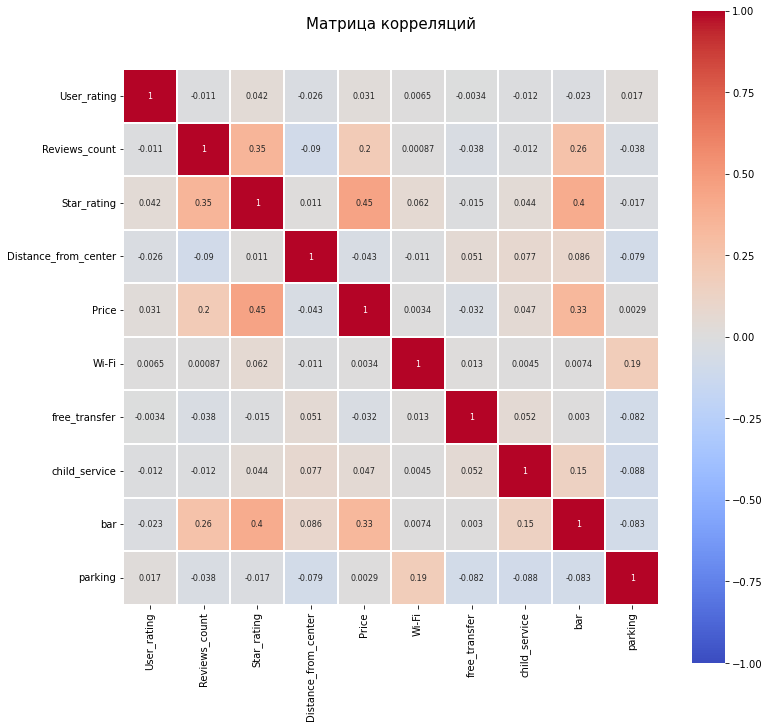

In [152]:
plt.figure(figsize=(12,12))
sns.heatmap(data.corr(), cmap='coolwarm',
            vmin=-1, vmax=1, 
            square=True,
            linewidths=0.1,annot_kws={"fontsize":8},
            annot=True);

plt.title('Матрица корреляций\n\n', fontsize = 15);

- Возможно, существует положительная зависимость между ценой и звездным рейтингом
- Возможно, существует положительная зависимость между звездным рейтингом и числом отзывов
- Возможно наблюдается положительная зависимость между звездным рейтингом и наличием бара

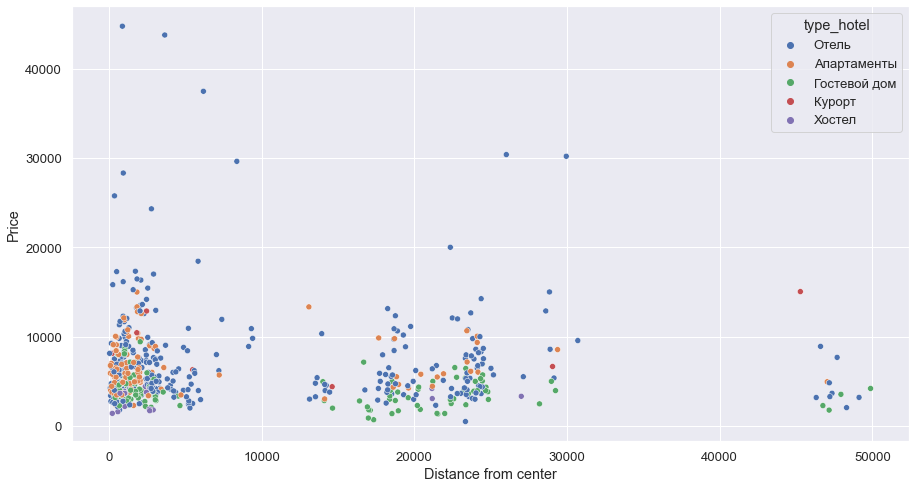

In [67]:
plt.figure(figsize=(15,8))
sns.set(font_scale=1.2)
sns.scatterplot(x='Distance_from_center', y='Price', hue = 'type_hotel', data=data)
plt.xlabel('Distance from center')
plt.ylabel('Price')
plt.show()

- По построенному выше графику можно сделать вывод о том, что содержатся выбросы - как по цене, так и по расстоянию от центра города. 
- При этом практически все выбросы по цене являются отелями
- Выбросы по расстоянию от центра города, в основном являются отелями и гостевыми домами. Так же имеется по 1 наблюдению-выбросу среди курорта (возможно это база Роза Хутор) и апартаменты
- Основная масса данных сосредоточена по цене до 10 тыс. рублей в день и до 5 км от центра города, при этом также наблюдается довольно большое количество наблюдений на расстоянии 15-30 км от центра города
- Таким образом, подтверждаются предположения о том, что среди отелей и гостевых домов содержатся выбросы по расстоянию от центра города, которые значительно увеличивают среднее расстояние (также подтверждается такая гипотеза и относительно курортов, так как в выборке их всего 8, поэтому даже 1-2 выброса могут оказать существенное влияние
- Также подтверждается гипотеза о наличии выбросов по цене среди отелей, о наличии так называемых отелей премиум-класса (4-5 звездочных), которые завышают средний показатель цены

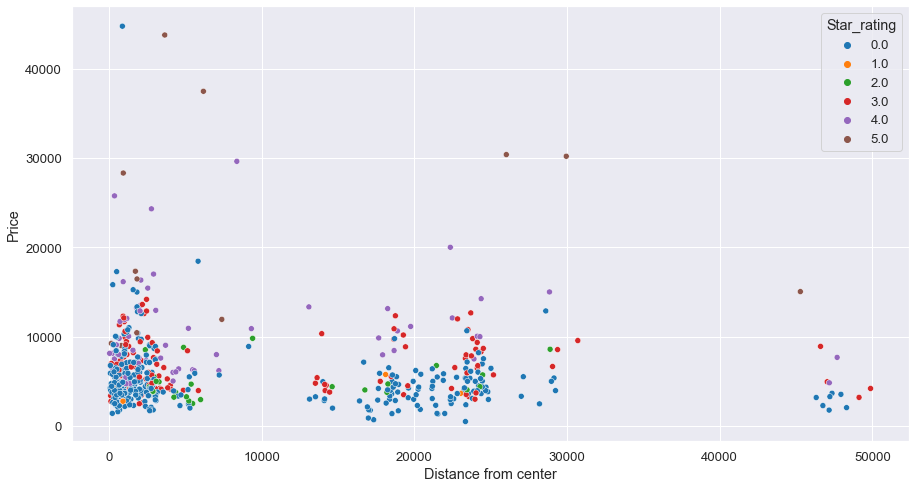

In [142]:
plt.figure(figsize=(15,8))
sns.set(font_scale=1.2)
sns.scatterplot(x='Distance_from_center', y='Price', hue = 'Star_rating', data=data, palette = 'tab10')
plt.xlabel('Distance from center')
plt.ylabel('Price')
plt.show()

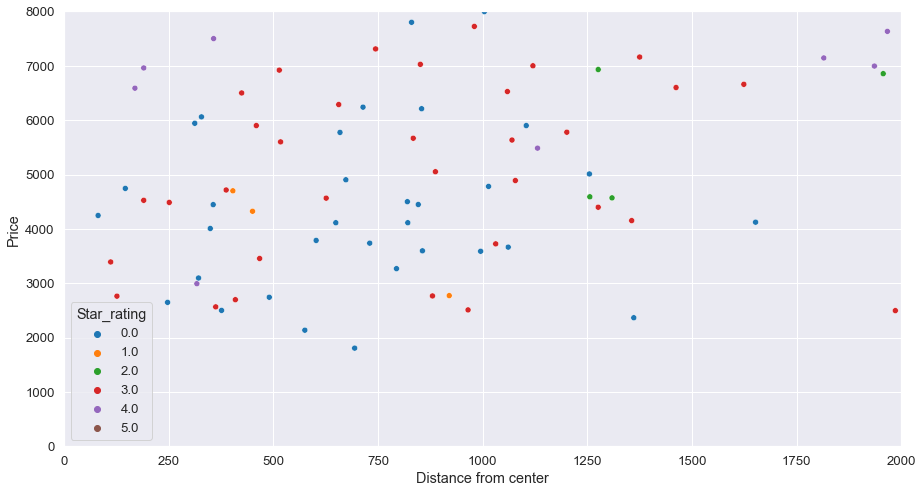

In [174]:
plt.figure(figsize=(15,8))
sns.set(font_scale=1.2)
sns.scatterplot(x='Distance_from_center', y='Price', hue = 'Star_rating', data=data[data.type_hotel == 'Отель'], palette = 'tab10')
plt.xlabel('Distance from center')
plt.ylim(0, 8000)
plt.xlim(0, 2000)
plt.ylabel('Price')
plt.show()

- Выбросы по цене наблюдаются среди 4-5 звездочных отелей (подтверждается предположение о наличии отелей премиум-класса. 
- Выбросы по цене с 0 звездами являются скорее всего следствием пропуска в данных
- По приближенной диаграмме можно сказать, что линейной обратной взаимосвязи между расстоянием от отеля до центра города и ценой не наблюдается

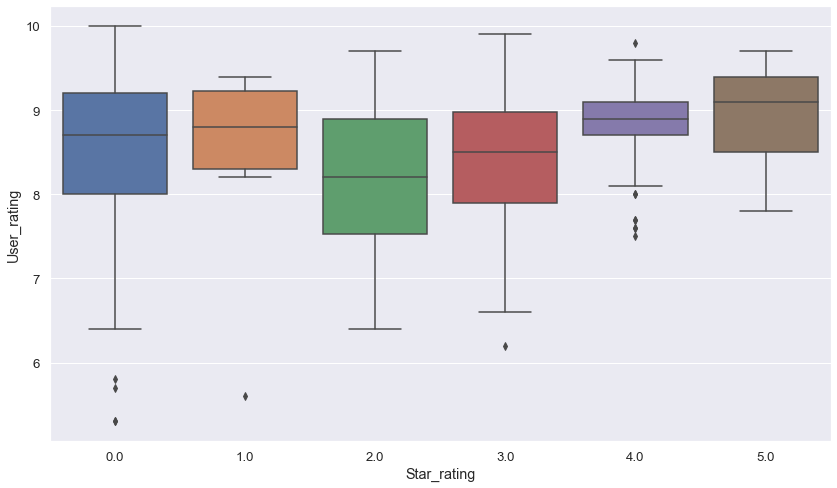

In [144]:
plt.figure(figsize=(14,8))
sns.set (font_scale= 1.2 )
sns.boxplot(x ="Star_rating", y ="User_rating", data = data)
plt.show()

- Пользовательский рейтинг мест проживания со звездным рейтингом 0 содержит выбросы. Возможно, обслуживание в местах, где звездный рейтинг являлся следствием не пропусков в датасете, а отсутствием такого рейтинга у отеля, как такового, хуже, чем у имеющих звезды
- Пользовательский рейтинг отелей с 1 звездой в целом не репрезентативен, так как выборка содержит всего 6 наблюдений
- Начиная с двух звезд, средний пользовательский рейтинг увеличивается с увеличением звездного рейтинга (прямое соотношение), что в целом достаточно логично - лучшие отели по критериям звезд имеют лучший рейтинг и в Интернет-отзывах

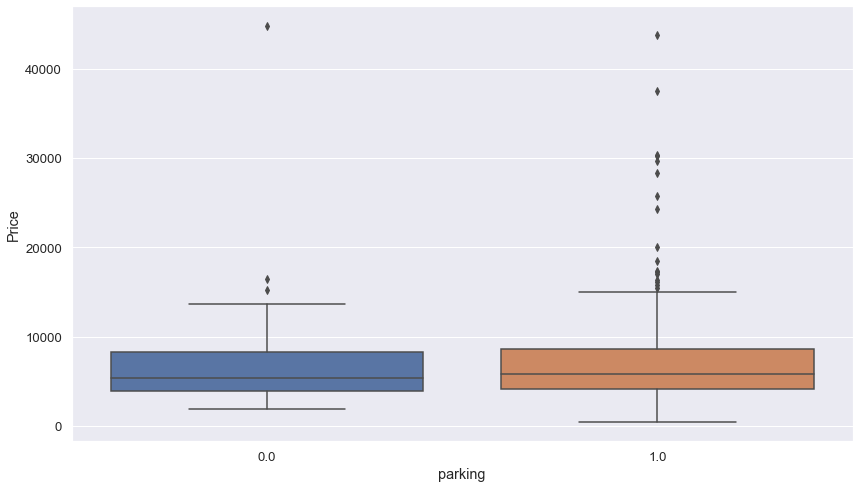

In [152]:
plt.figure(figsize=(14,8))
sns.set (font_scale= 1.2 )
sns.boxplot(x ="parking", y ="Price", data = data[data.type_hotel == 'Отель'])
plt.show()

- В целом, цена за номера в отелях, предоставляющих услугу бесплатной парковки равна
- Много выбросов из числа отелей, предоставляющих парковку. Можно сделать вывод, что премиум-отели со стоимостью выше 15000 рублей в день гораздо чаще предоставляют парковку, чем нет

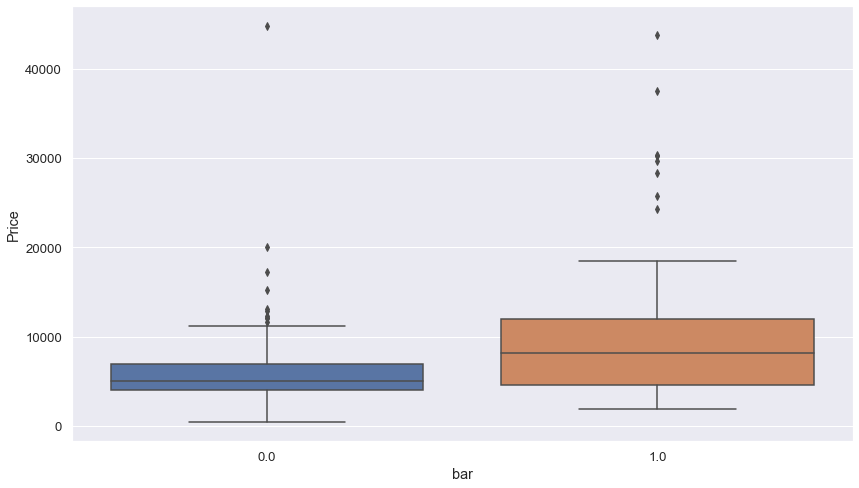

In [168]:
plt.figure(figsize=(14,8))
sns.set (font_scale= 1.2 )
sns.boxplot(x ="bar", y ="Price", data = data[data.type_hotel == 'Отель'])
plt.show()

- Из графика следует, что в обеих категориях отелей (с баром и без) существуют выбросы
- При этом, среднее значение цены отелей с баром выше, чем без
- Гипотеза о прямой зависимости стоимости номера в отеле от наличия бара не принимается

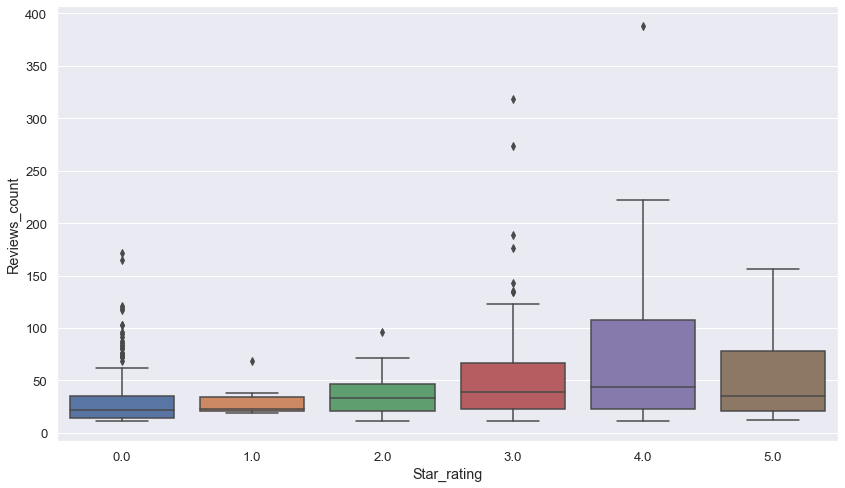

In [145]:
plt.figure(figsize=(14,8))
sns.set (font_scale= 1.2 )
sns.boxplot(x ="Star_rating", y ="Reviews_count", data = data)
plt.show()

- В среднем, число отзывов для мест размещения с разным количеством звезд находится приблизительно на одном уровне 
- Среди отелей с 0 звездами (пропуски в данных или отсутствие рейтинга в принципе), с 3 звездами содержится много выбросов
- Гипотеза о наличии прямой взаимосвязи между звездным рейтингом и числом отзывов, на наш взгляд не подтвердилось

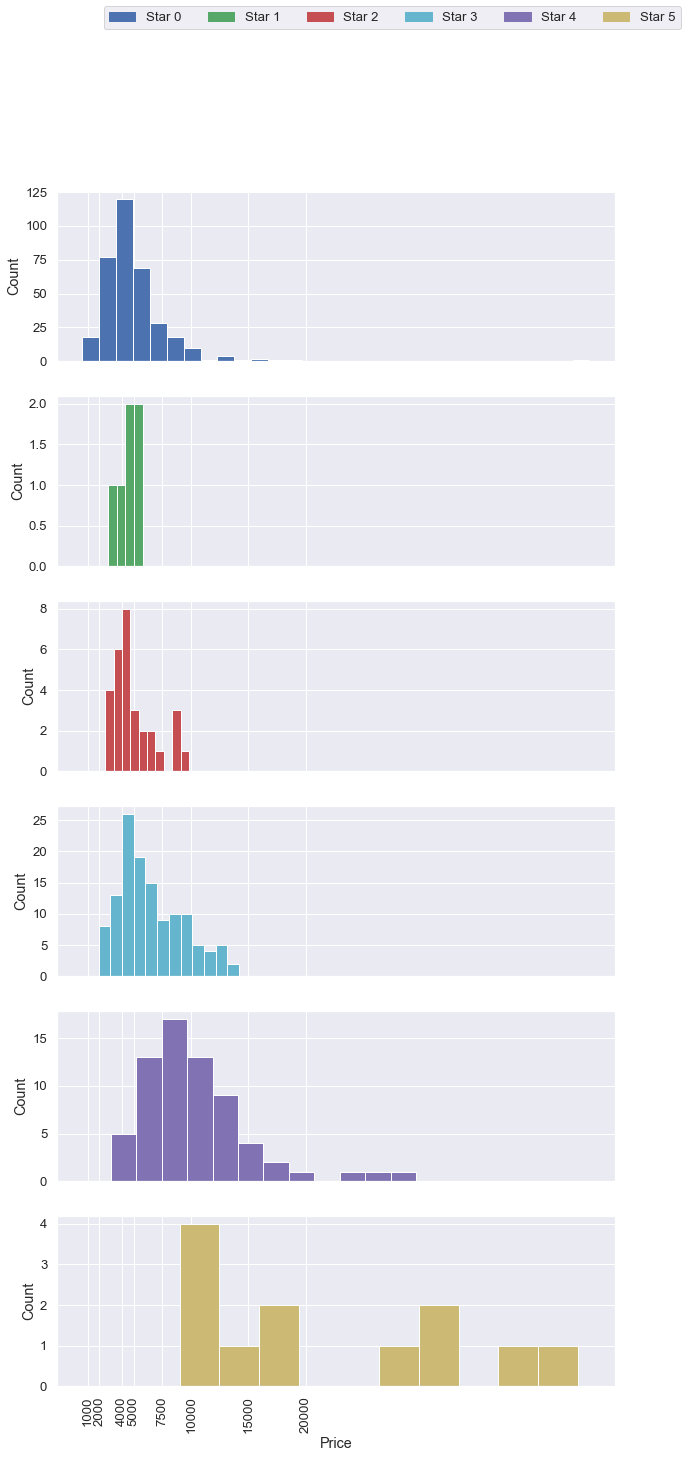

In [162]:
data_star_0 = data[data.Star_rating == 0]
data_star_1 = data[data.Star_rating == 1]
data_star_2 = data[data.Star_rating == 2]
data_star_3 = data[data.Star_rating == 3]
data_star_4 = data[data.Star_rating == 4]
data_star_5 = data[data.Star_rating == 5]
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1, figsize=(10, 22), sharex = True)
ax1.hist(x = 'Price', data = data_star_0, color = 'b', bins = 30)
ax1.set_ylabel('Count')
ax2.hist(x = 'Price', data = data_star_1, color = 'g', bins = 4)
ax2.set_ylabel('Count')
ax3.hist(x = 'Price', data = data_star_2, color = 'r',  bins = 10)
ax3.set_ylabel('Count')
ax4.set_ylabel('Count')
ax5.set_ylabel('Count')
ax6.set_ylabel('Count')
ax6.set_xlabel('Price')
ax6.set_xticks([1000, 2000, 4000, 5000, 7500, 10000, 15000, 20000])
ax4.hist(x = 'Price', data = data_star_3, color = 'c',  bins = 12)
ax5.hist(x = 'Price', data = data_star_4, color = 'm',  bins = 12)
ax6.hist(x = 'Price', data = data_star_5, color = 'y',  bins = 10)
labels = ['Star 0', 'Star 1', 'Star 2', 'Star 3', 'Star 4', 'Star 5']
colors = ['b', 'g', 'r', 'c', 'm', 'y']
handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in colors]
plt.figlegend(handles, labels, ncol=6)
plt.xticks(rotation=90)
plt.show()

- Как следует из графиков, цены на номера находятся в прямой зависимости от звездного рейтинга: с увеличением количества звезд увеличивается (смещается вправо) и мода цены на номер в объекте размещения. 
- Таким образом, гипотеза о прямой взаимосвязи между звездным рейтингом и ценой подтверждается

 <a name="mo"></a>
## Машинное обучение

Для нас наиболее важным критерием является цена, при этом совсем необязательно чтобы она была низкой, так как слишком низкая цена может являться следствием недостатков в месте проживания

Подходящий ценовой диапазон для нас - от 1200 до 5000 рублей в день, поэтому добавим новый признак - Price1 - индикатор (1 - если объект попадает в наш ценовой диапазон, 0 - если нет), старую колонку с ценой (Price) удалим

Также преобразуем колонку type_hotel - с помощью метода get_dummies библиотеки pandas перекодируем категориальную переменную
В итоге будет создана n-1 новая колонка, где n - количество уникальных значений колонки type_hotel

In [177]:
data = pd.read_csv('New_preprocessed.csv')
data['Price1'] = data['Price'].apply(lambda x: 1 if (x <= 5000) and (x >= 1200) else 0)
k = data.drop(columns = 'Price')
k = pd.get_dummies(k, drop_first = True)

In [178]:
k.head(10)

,User_rating,Reviews_count,Star_rating,Distance_from_center,Wi-Fi,free_transfer,child_service,bar,parking,Price1,type_hotel_Гостевой дом,type_hotel_Курорт,type_hotel_Отель,type_hotel_Хостел
0,8.2,107.0,4.0,317,1.0,0.0,0.0,1.0,1.0,1,0,0,1,0
1,8.8,99.0,3.0,3338,1.0,0.0,0.0,0.0,1.0,1,0,0,1,0
2,9.0,96.0,0.0,1145,1.0,0.0,0.0,0.0,1.0,1,0,0,0,0
3,9.0,116.0,4.0,1875,1.0,0.0,0.0,0.0,1.0,0,0,0,0,0
4,9.0,103.0,0.0,24457,1.0,0.0,0.0,1.0,1.0,0,1,0,0,0
5,9.3,222.0,4.0,230,1.0,0.0,0.0,0.0,1.0,0,0,1,0,0
6,8.0,134.0,3.0,980,1.0,0.0,0.0,0.0,1.0,0,0,0,1,0
7,8.4,96.0,2.0,18487,0.0,0.0,0.0,0.0,0.0,1,0,0,1,0
8,8.5,18.0,0.0,1989,1.0,0.0,0.0,0.0,1.0,1,1,0,0,0
9,8.9,38.0,3.0,387,1.0,0.0,0.0,0.0,1.0,1,0,0,1,0


Будем решать задачу классификации, целевая переменная - Price1, где 1 - место размещения подходит нам по цене, 0 - не подходит

Построим случайный лес для решения задачи классификации

In [179]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

Разделим нашу выборку на обучающую, валидационную и тестовую в пропорции 0.49: 0.21 : 0.3

На валидационной выборке будем подбирать гиперпараметры

In [180]:
y_data = k['Price1']
X_data = k.drop(columns = ['Price1'])
X_train_full, X_test, y_train_full, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.3, random_state=42)

Так как случайный лес имеет такой гиперпараметр, как число строящихся деревьев, от которого существенно зависит скорость обучения, то построим зависимость значения метрики AUC-ROC от количества деревьев (обучать случайный лес здесь будем на полной обучающей выборке)

In [165]:
n_estimators = [1, 5, 10, 20,30, 40, 50, 60, 80, 100, 200, 300,  500, 700, 900, 1000, 1100, 1300, 1500]
auc_scores = []
for n in n_estimators:
    clf = RandomForestClassifier(n_estimators=n, random_state=123)
    clf.fit(X_train_full, y_train_full)
    y_pred = clf.predict(X_test)
    auc = roc_auc_score(y_test, y_pred)
    auc_scores.append(auc)

In [166]:
import matplotlib.pyplot as plt
import numpy as np

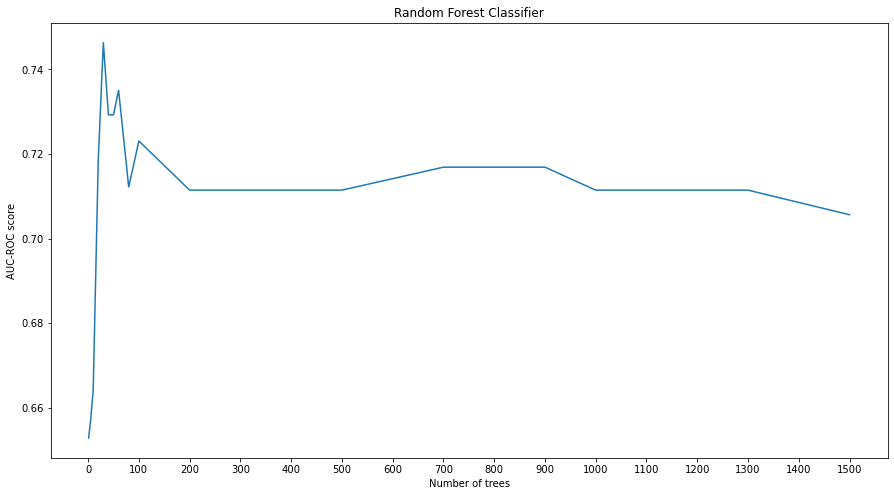

In [167]:
plt.figure(figsize = (15, 8))
plt.xlabel('Number of trees')
plt.ylabel('AUC-ROC score')
plt.xticks(np.arange(0, 1700, step=100))
plt.title('Random Forest Classifier')
plt.plot(n_estimators, auc_scores)
plt.show()

In [168]:
max_auc_roc_score = max(enumerate(auc_scores),key=lambda x: x[1])[0]
n_estimators[max_auc_roc_score]

30

Как видно и из графика, и из предыдущей ячейки, максимальное значение метрики AUC-ROC достигается при количестве деревьев - 30, при меньшем значении наш случайный лес недообучается, при большем - ненамного переобучается 

Поэтому зафиксируем параметр n_estimators = 30, будем подбирать параметры максимальной глубины и минимального числа объектов, необходимого для того, чтобы узел дерева мог бы расщепиться.

Обучать модель будем на валидационной выборке с помощью метрики f1-score

In [169]:
from sklearn.model_selection import cross_val_score
max_depth_candidates = [i for i in range(1, 21)]
min_samples_split_candidates = [i for i in range(2, 21)]
f1_scores = 0
for max_depth in max_depth_candidates:
    for min_samples_split in min_samples_split_candidates:
        rf = RandomForestClassifier(n_estimators = 30, max_depth = max_depth, min_samples_split =  min_samples_split,\
                                    random_state = 123)
        rf.fit(X_train, y_train)
        f1 = f1_score(y_val, rf.predict(X_val))
        scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='f1_macro')
        f1 = scores.mean()
        if f1 > f1_scores:
            f1_scores = f1
            max_depth_best = max_depth
            min_samples_split_best = min_samples_split
print('best f1 score: ', f1_scores, '\n', 'best max depth: ', max_depth_best, '\n', 'best min samples split: ',\
      min_samples_split_best, sep ='')

best f1 score: 0.6808799790375238
best max depth: 7
best min samples split: 10


Получилось, что наилучшей метрики f1 score модель добивается при max depth = 7, min samples split = 10
Посмотрим на качество нашей модели на тестовой выборке с помощью метрик 

In [181]:
rf =RandomForestClassifier(n_estimators=30, max_depth = 7, min_samples_split =  10,\
                                    random_state=123)
rf.fit(X_train_full, y_train_full)
rf_pred = rf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, rf_pred))
print("Precision:", precision_score(y_test, rf_pred))
print("Recall:", recall_score(y_test, rf_pred))
print("AUC-ROC:" , roc_auc_score(y_test, rf_pred))

Accuracy: 0.7191011235955056
Precision: 0.7029702970297029
Recall: 0.7802197802197802
AUC-ROC: 0.7176960970064418


In [182]:
rf =RandomForestClassifier(random_state=123)
rf.fit(X_train_full, y_train_full)
rf_pred = rf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, rf_pred))
print("Precision:", precision_score(y_test, rf_pred))
print("Recall:", recall_score(y_test, rf_pred))
print("AUC-ROC:" , roc_auc_score(y_test, rf_pred))

Accuracy: 0.6853932584269663
Precision: 0.6966292134831461
Recall: 0.6813186813186813
AUC-ROC: 0.6854869268662372


За счет подбора гиперпараметров удалось увеличить все метрики качества

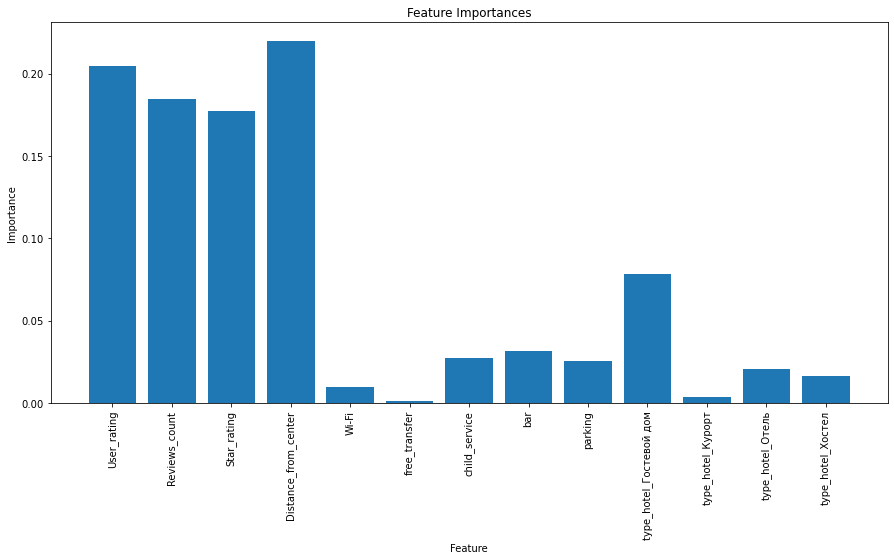

In [172]:
rf =RandomForestClassifier(n_estimators=200, max_depth = 12, min_samples_split =  4,\
                                    random_state=123)
rf.fit(X_train_full, y_train_full)

important_features = rf.feature_importances_
names = list(X_train_full.columns)
important_list = pd.DataFrame({'feature': names, 'coef': important_features})

plt.figure(figsize=(15, 7))
plt.bar(important_list['feature'], important_list['coef'])
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()

Наиболее важными признаками при классификации оказались:
- Расстояние до центра города
- Звездный рейтинг
- Пользовательский рейтинг
- Число отзывов